# Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
from pylab import *
from pprint import pprint
from random import uniform as rand
%matplotlib inline

# Import data

Import the given excel file.

In [3]:
data_df = pd.read_excel('./data_case.xlsx', index_col='Date')
data_df = data_df.reindex(sorted(data_df.columns), axis=1)
data_df.head()

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Date,,,,,
2004-12-31,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.061548,0.014354,0.019900,0.028100,-0.007989
2005-01-14,0.037780,-0.003776,0.003577,-0.003210,-0.007760
2005-01-21,0.007729,-0.007996,0.001278,0.001171,0.009977
2005-01-28,-0.013148,0.006571,0.002871,0.001559,-0.018529


Visualization of the classes:

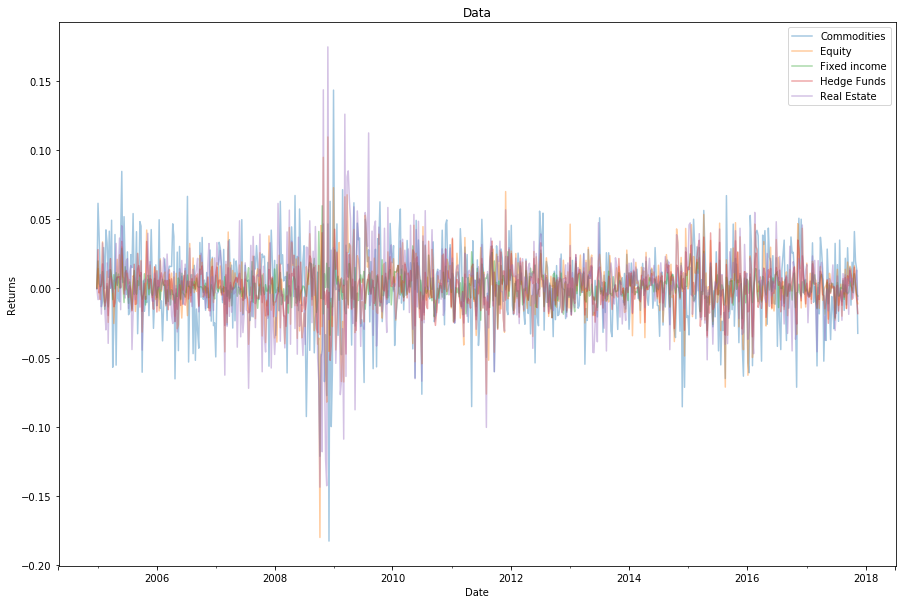

In [4]:
data_df.plot(alpha=.4, figsize = (15,10), title='Data')
plt.ylabel('Returns');

# Historical returns and volatilities

Calculate the means of the returns and the respective volatilities for the 5 classes given.

Firstly, returns:

In [5]:
return_mean = data_df.mean()
annualised_return = return_mean * 52
annualised_return

Commodities     0.057280
Equity          0.093558
Fixed income    0.044531
Hedge Funds     0.023070
Real Estate     0.086696
dtype: float64

Secondly, standard deviations:

In [6]:
return_stdev = data_df.std()
annualised_stdev = return_stdev * np.sqrt(52)
annualised_stdev

Commodities     0.214509
Equity          0.163519
Fixed income    0.070714
Hedge Funds     0.097795
Real Estate     0.207877
dtype: float64

Let us check the relatioships between E(return) and σ:

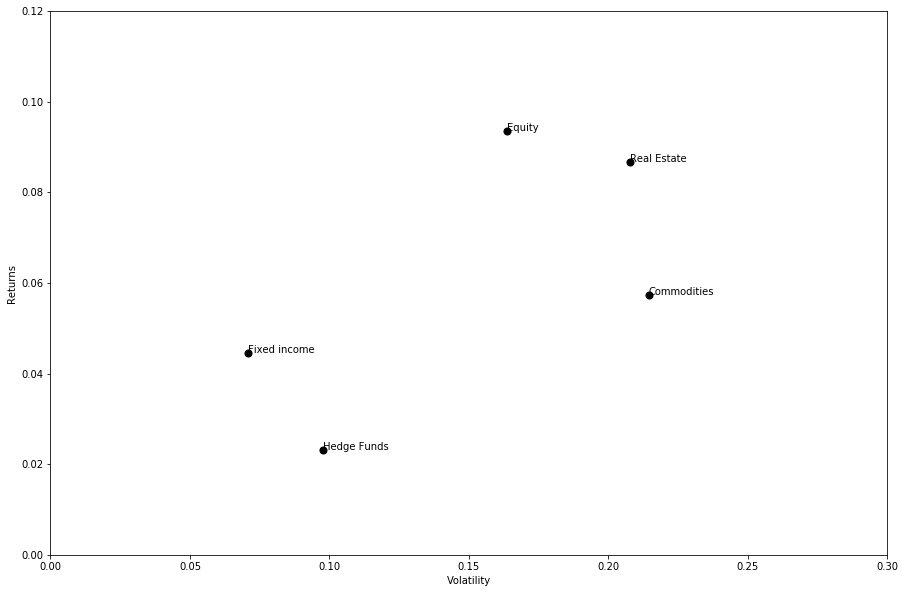

In [7]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(annualised_stdev, annualised_return, marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data_df.columns.tolist()):
    ax.annotate(txt, (annualised_stdev.tolist()[i],annualised_return.tolist()[i]))
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))
plt.xlabel('Volatility')
plt.ylabel('Returns');

# Portfolios

# Long

Given that the risk free rate is 3%:

In [15]:
r_f = .03

Set number of runs of random portfolio weights:

In [16]:
num_portfolios = 1000000

Set some variables:

In [17]:
#list of stocks in portfolio
stocks = data_df.columns.tolist()

#specify returns dataframe
returns = data_df
 
#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(stocks)-1,num_portfolios))

## Calculate Returns, Volatility, SR, and weights for the 5 classes

In [18]:
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 52
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(52)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-r_f) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

Convert results array to Pandas DataFrame:

In [19]:
results_frame_l = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_frame_l.head()

,ret,stdev,sharpe,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
0,0.062837,0.106925,0.307104,0.201786,0.212334,0.244155,0.142791,0.198934
1,0.054478,0.088683,0.276018,0.084976,0.017258,0.427459,0.185659,0.284647
2,0.054356,0.092603,0.263015,0.212725,0.114596,0.319616,0.210483,0.142580
3,0.055241,0.094797,0.266267,0.196624,0.266224,0.255050,0.263152,0.018951
4,0.068902,0.116431,0.334118,0.107645,0.357160,0.183827,0.146602,0.204766


Get Sharpe ratio and Minimum Variance Portfolio

In [20]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port_l = results_frame_l.iloc[results_frame_l['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port_l = results_frame_l.iloc[results_frame_l['stdev'].idxmin()]

## Minimum Variance Portfolio

In [21]:
print('Standard Deviation of the Minimum Variance Portfolio:', min_vol_port_l[1])

Standard Deviation of the Minimum Variance Portfolio: 0.0652315108478


Weights:

In [22]:
print(min_vol_port_l[3:]*100)

Commodities      8.243461
Equity           9.512950
Fixed income    78.757981
Hedge Funds      2.442050
Real Estate      1.043558
Name: 51549, dtype: float64


## Sharpe Ratio

In [23]:
print('Sharpe ratio:', min_vol_port_l[2])

Sharpe ratio: 0.309076281591


Weights:

In [24]:
print(max_sharpe_port_l[3:]*100)

Commodities      1.321481
Equity          45.237868
Fixed income    51.908936
Hedge Funds      0.367706
Real Estate      1.164008
Name: 442121, dtype: float64


## Optimal Portfolio

This is how our tangency portfolio looks like:

In [25]:
max_sharpe_port_l

ret             0.067290
stdev           0.087030
sharpe          0.428475
Commodities     0.013215
Equity          0.452379
Fixed income    0.519089
Hedge Funds     0.003677
Real Estate     0.011640
Name: 442121, dtype: float64

We know that the investor has a Investor quadratic utility function with a risk aversion level ($\gamma$) of 6.
$$ U(r_P) = E(r_P)- \gamma \frac{\sigma_P^2}{2} $$

In [27]:
r_T_l = max_sharpe_port_l[0]
sigma_T_l = max_sharpe_port_l[1]
r_f = r_f
gamma = 6

To find optimal portfolio choice:
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

In [30]:
w_T_l = (r_T_l-r_f)/(gamma*(sigma_T_l**2))

In [31]:
print('Optimal weight on the tangency portfolio:', round(w_T_l,2))

Optimal weight on the tangency portfolio: 0.82


### Expected return:

In [32]:
E_o_l = w_T_l*r_T_l + (1-w_T_l)*r_f

In [33]:
print('Expected return:', round(E_o_l*100,2),'%')

Expected return: 6.06 %


### Standard deviation:

In [34]:
sigma_o_l = w_T_l*sigma_T_l

In [35]:
print('Standard Deviation:', round(sigma_o_l*100,2),'%')

Standard Deviation: 7.14 %


Also, his utility:

In [36]:
U_o_l = E_o_l - gamma*(sigma_o_l**2)/2
print('Utility:', round(U_o_l,2))

Utility: 0.05


# Portfolios graph

In [37]:
def graph_formulas(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)  

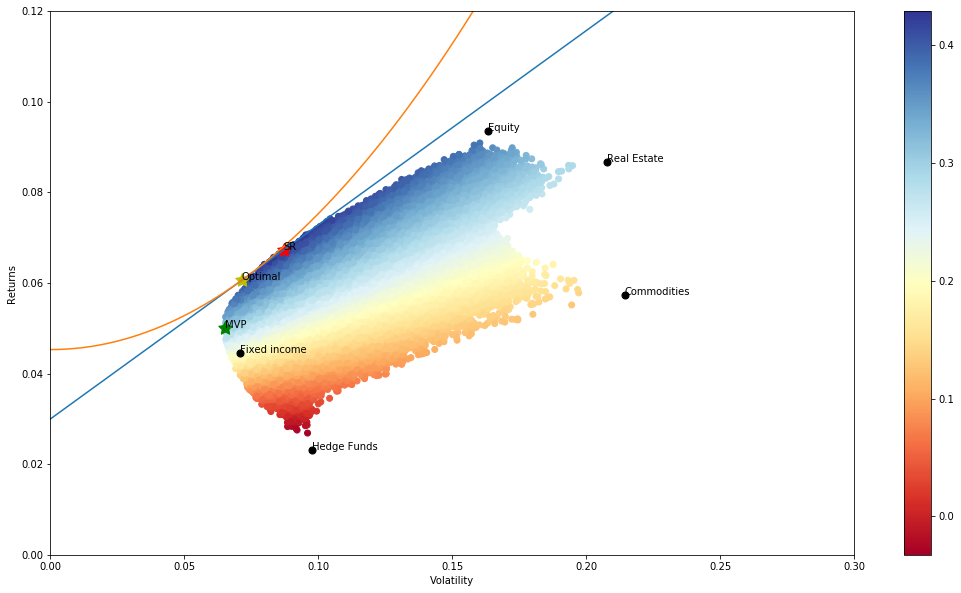

In [38]:
# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame_l.stdev,results_frame_l.ret,c=results_frame_l.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(annualised_stdev, annualised_return, marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data_df.columns.tolist()):
    plt.annotate(txt, (annualised_stdev.tolist()[i],annualised_return.tolist()[i]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port_l[1],min_vol_port_l[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_port_l[1],min_vol_port_l[0]))    
    
# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port_l[1],max_sharpe_port_l[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_port_l[1],max_sharpe_port_l[0]))
             
# Add CML line
graph_formulas(lambda x: (r_f + (max_sharpe_port_l[0]-r_f)*(x/max_sharpe_port_l[1])), np.linspace(0.0,0.3, 100))

# Add optimal portfolio 
plt.scatter(sigma_o_l,E_o_l,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (sigma_o_l,E_o_l))

# Add investors utility curve
graph_formulas(lambda x: (U_o_l+gamma*(x**2)/2), np.linspace(0.0,0.3, 100))

plt.show();

<br>

# Short/Long

Given that the risk free rate is 3%:

In [32]:
r_f = .03

Set number of runs of random portfolio weights:

In [33]:
num_portfolios = 2500000

Set some variables:

In [ ]:
#list of stocks in portfolio
stocks = data_df.columns.tolist()

#specify returns dataframe
returns = data_df
 
#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(stocks)-1,num_portfolios))

## Calculate Returns, Volatility, SR, and weights for the 5 classes

In [ ]:
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.uniform(-2,2,5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 52
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(52)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-r_f) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

Convert results array to Pandas DataFrame:

In [ ]:
results_frame_sl = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_frame_sl.head()

Get Sharpe ratio and Minimum Variance Portfolio

In [ ]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port_sl = results_frame_sl.iloc[results_frame_sl['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port_sl = results_frame_sl.iloc[results_frame_sl['stdev'].idxmin()]

## Minimum Variance Portfolio

In [ ]:
print('Standard Deviation of the Minimum Variance Portfolio:', min_vol_port_sl[1])

Weights:

In [ ]:
print(min_vol_port_sl[3:]*100)

## Sharpe Ratio

In [ ]:
print('Sharpe ratio:', min_vol_port_sl[2])

Weights:

In [ ]:
print(max_sharpe_port_sl[3:]*100)

## Optimal Portfolio

This is how our tangency portfolio looks like:

In [ ]:
max_sharpe_port_sl

We know that the investor has a Investor quadratic utility function with a risk aversion level ($\gamma$) of 6.
$$ U(r_P) = E(r_P)- \gamma \frac{\sigma_P^2}{2} $$

In [ ]:
r_T_sl = max_sharpe_port_sl[0]
sigma_T_sl = max_sharpe_port_sl[1]
r_f = r_f
gamma = 6

To find optimal portfolio choice:
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

In [ ]:
w_T_sl = (r_T_sl-r_f)/(gamma*(sigma_T_sl**2))

In [ ]:
print('Optimal weight on the tangency portfolio:', round(w_T_sl,2))

### Expected return:

In [ ]:
E_o_sl = w_T_sl*r_T_sl + (1-w_T_sl)*r_f

In [ ]:
print('Expected return:', round(E_o_sl*100,2),'%')

### Standard deviation:

In [ ]:
sigma_o_sl = w_T_sl*sigma_T_sl

In [ ]:
print('Standard Deviation:', round(sigma_o_sl*100,2),'%')

Also, his utility:

In [ ]:
U_o_sl = E_o_sl - gamma*(sigma_o_sl**2)/2
print('Utility:', round(U_o_sl,2))

# Portfolios graph

In [ ]:
def graph_formulas(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)  

In [ ]:
# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.ylim((0.00,0.25))
plt.xlim((0.00,0.3))

# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame_sl.stdev,results_frame_sl.ret,c=results_frame_sl.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(annualised_stdev, annualised_return, marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data_df.columns.tolist()):
    plt.annotate(txt, (annualised_stdev.tolist()[i],annualised_return.tolist()[i]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port_sl[1],min_vol_port_sl[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_port_sl[1],min_vol_port_sl[0]))    
    
# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port_sl[1],max_sharpe_port_sl[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_port_sl[1],max_sharpe_port_sl[0]))
             
# Add CML line
graph_formulas(lambda x: (r_f + (max_sharpe_port_sl[0]-r_f)*(x/max_sharpe_port_sl[1])), np.linspace(0.0,0.3, 100))

# Add optimal portfolio 
plt.scatter(sigma_o_sl,E_o_sl,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (sigma_o_sl,E_o_sl))

# Add investors utility curve
graph_formulas(lambda x: (U_o_sl+gamma*(x**2)/2), np.linspace(0.0,0.3, 100))

plt.show();

<br>